In [3]:
import pandas as pd
import numpy as np
import gzip

In [4]:
#read ClinVar data:
ClinVar_01_25 = pd.read_csv('variant_summary_2025-01.txt.gz', sep='\t')

#filter on SNVs
ClinVar_01_25_SNV = ClinVar_01_25[ClinVar_01_25['Type'] == 'single nucleotide variant']

#grch38
ClinVar_01_25_SNV = ClinVar_01_25_SNV[ClinVar_01_25_SNV['Assembly'] == 'GRCh38']

#filter ClinicalSignificance
ClinVar_01_25_SNV_simple = ClinVar_01_25_SNV[ClinVar_01_25_SNV['ClinicalSignificance'].str.contains('pathogenic|benign|uncertain', case=False, na=False)]
ClinVar_01_25_SNV_simple = ClinVar_01_25_SNV_simple[~ClinVar_01_25_SNV_simple['ClinicalSignificance'].str.contains('penetrance|drug|other|protective|risk', case=False, na=False)]

#filter out things that are below 1 star
ClinVar_01_25_SNV_simple = ClinVar_01_25_SNV_simple[~ClinVar_01_25_SNV_simple['ReviewStatus'].str.contains('no assertion', case=False, na=False)]

#optional drop columns you don't need:
#ClinVar_01_25_SNV_simple = ClinVar_01_25_SNV_simple.drop(columns=["OtherIDs", "SubmitterCategories", "VariationID"])

#gencc moderate and up
unique_gencc = pd.read_csv('unique_gencc.csv')

/tmp/18553329.1.shendure-login.q/ipykernel_2135589/122012880.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  ClinVar_01_25 = pd.read_csv('variant_summary_2025-01.txt.gz', sep='\t')


In [12]:
import re

# Extract the p.variant into a new column, handling cases where p.variant is not present
ClinVar_01_25_SNV_simple['p.variant'] = ClinVar_01_25_SNV_simple['Name'].str.extract(r'\(p\.([A-Za-z]{3}\d+[A-Za-z]*?)\)')[0]

amino_acid_map = {
    'Ala': 'A', 'Cys': 'C', 'Asp': 'D', 'Glu': 'E', 'Phe': 'F',
    'Gly': 'G', 'His': 'H', 'Ile': 'I', 'Lys': 'K', 'Leu': 'L',
    'Met': 'M', 'Asn': 'N', 'Pro': 'P', 'Gln': 'Q', 'Arg': 'R',
    'Ser': 'S', 'Thr': 'T', 'Val': 'V', 'Trp': 'W', 'Tyr': 'Y',
    'Ter': '*'  # Special case for stop codon
}

# Function to replace three-letter codes with single-letter codes using regex
def replace_aa_codes(p_variant):
    if isinstance(p_variant, str):  # Check if p_variant is a string
        # Define a regex pattern for matching three-letter amino acid codes
        pattern = r'([A-Z][a-z][a-z])'
        
        # Replace three-letter codes with single-letter codes
        def replace_match(match):
            three_letter_code = match.group(0)  # Get the matched three-letter code
            return amino_acid_map.get(three_letter_code, three_letter_code)  # Return single-letter or original

        # Use regex sub with the replacement function
        replaced_variant = re.sub(pattern, replace_match, p_variant)
        return replaced_variant
    
    return ''  # Return empty string for non-matching cases

# Apply the replacement function
ClinVar_01_25_SNV_simple['p.variant'] = ClinVar_01_25_SNV_simple['p.variant'].apply(replace_aa_codes)

ClinVar_01_25_SNV_simple_missense = ClinVar_01_25_SNV_simple[~ClinVar_01_25_SNV_simple['p.variant'].str.endswith(('*', '='))]
ClinVar_01_25_SNV_simple_missense = ClinVar_01_25_SNV_simple_missense[ClinVar_01_25_SNV_simple_missense['p.variant'].notna() & (ClinVar_01_25_SNV_simple_missense['p.variant'] != '')]


In [13]:
#load hap1 data:
hap1_essential = pd.read_csv("hap1_essential.csv")
hap1_essential = hap1_essential.rename(columns={'selected': 'hap1_essential'})

#merge with ClinVar
CV_missense_hap1 = pd.merge(ClinVar_01_25_SNV_simple_missense, hap1_essential, left_on='GeneSymbol', right_on='Gene', how='left')

In [14]:
uniprot_len_loc = pd.read_csv("uniprot_len_loc_2.csv")

In [15]:
# Create expanded Y dataframe with both Gene_Name and Synonyms
Y_expanded = []
# Add rows for Gene_Name
Y_temp = uniprot_len_loc.copy()
Y_temp['match_column'] = Y_temp['Gene_Name']
Y_expanded.append(Y_temp)
# Add rows for each synonym
Y_synonyms = uniprot_len_loc.copy()
Y_synonyms['Synonyms'] = Y_synonyms['Synonyms'].str.split(',')
Y_synonyms = Y_synonyms.explode('Synonyms')
Y_synonyms['Synonyms'] = Y_synonyms['Synonyms'].str.strip()
Y_synonyms['match_column'] = Y_synonyms['Synonyms']
Y_expanded.append(Y_synonyms)
# Combine all possible matches
Y_all_matches = pd.concat(Y_expanded, ignore_index=True)
# Remove duplicates (prioritize Gene_Name matches)
Y_all_matches = Y_all_matches.drop_duplicates(subset=['match_column'], keep='first')

# Do the merge with suffixes to handle duplicate column names
CV_missense_hap1_loc_len = pd.merge(CV_missense_hap1, Y_all_matches, 
                                   left_on='GeneSymbol', right_on='match_column', 
                                   how='left', suffixes=('', '_y'))

# Function to clean up redundant columns
def clean_redundant_columns(df):
    """
    Remove redundant columns that are identical between _x and _y versions,
    keeping the original (non-suffixed) version when possible.
    """
    columns_to_drop = []
    
    # Find all columns that have _y suffix
    y_columns = [col for col in df.columns if col.endswith('_y')]
    
    for y_col in y_columns:
        base_name = y_col[:-2]  # Remove '_y' suffix
        
        # Check if there's a corresponding column without suffix
        if base_name in df.columns:
            # Compare the columns - if they're identical (ignoring NaN), drop the _y version
            # If original has NaN and _y has values, use _y to fill NaN
            original_col = df[base_name]
            y_col_data = df[y_col]
            
            # Fill NaN values in original with values from _y column
            df[base_name] = original_col.fillna(y_col_data)
            
            # Mark _y column for removal
            columns_to_drop.append(y_col)
        else:
            # If no original column exists, rename _y column to remove suffix
            df[base_name] = df[y_col]
            columns_to_drop.append(y_col)
    
    # Drop the redundant _y columns
    df = df.drop(columns=columns_to_drop)
    
    return df

# Clean up the merged dataframe
CV_missense_hap1_loc_len = clean_redundant_columns(CV_missense_hap1_loc_len)

# Optional: Drop the helper match_column if you don't need it
if 'match_column' in CV_missense_hap1_loc_len.columns:
    CV_missense_hap1_loc_len = CV_missense_hap1_loc_len.drop('match_column', axis=1)

print(f"Final dataframe shape: {CV_missense_hap1_loc_len.shape}")
print(f"Columns: {list(CV_missense_hap1_loc_len.columns)}")

Final dataframe shape: (1505844, 62)
Columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession', 'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele', 'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID', 'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF', 'SomaticClinicalImpact', 'SomaticClinicalImpactLastEvaluated', 'ReviewStatusClinicalImpact', 'Oncogenicity', 'OncogenicityLastEvaluated', 'ReviewStatusOncogenicity', 'p.variant', 'Gene', 'ENSEMBL_ID', 'tot.sense', 'tot.anti', 'p.val', 'q.val', 'ratio', 'hap1_essential', 'Unnamed: 0', 'Entry', 'Reviewed', 'Entry Name', 'Protein names', 'Gene Names', 'Organism', 'Length', 'Ensembl', 'Subcellular location [CC]', 'Gene_Name', 'Sy

In [19]:
CV_missense_hap1_loc_len['cytoplasmic'] = CV_missense_hap1_loc_len['Subcellular location [CC]'].str.contains('cytoplasm|cell membrane|multi-pass|projection|single-pass|reticulum|mito', case=False, na=False).map({True: 'yes', False: 'no'})

In [20]:
CV_missense_hap1_loc_len['nuclear'] = CV_missense_hap1_loc_len['Subcellular location [CC]'].str.contains('nucle', case=False, na=False).map({True: 'yes', False: 'no'})

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vus_collectors_curve_four_panel(df):
   
    # Step 1: Filter for VUS annotations (including secreted genes)
    vus_data = df[df['ClinicalSignificance'] == 'Uncertain significance']
    
    # Step 2: Calculate the VUS count for each gene
    vus_count_per_gene = vus_data.groupby('GeneSymbol').size().reset_index(name='VUS_count')
    
    # Step 3: Merge VUS count with the original dataframe to get the gene lengths AND class
    # Use the existing 'class' column that already has the hierarchical classification
    gene_info = df[['GeneSymbol', 'Length', 'class']].drop_duplicates()
    vus_count_per_gene = vus_count_per_gene.merge(gene_info, on='GeneSymbol')
    
    # Step 4: Use the existing class column (no need to reclassify)
    vus_count_per_gene['cellular_class'] = vus_count_per_gene['class']
    
    # Step 5: Calculate VUS density (VUS count / Length)
    vus_count_per_gene['VUS_density'] = vus_count_per_gene['VUS_count'] / vus_count_per_gene['Length']
    
    # Step 6: Sort genes by VUS density in descending order
    vus_count_per_gene = vus_count_per_gene.sort_values(by='VUS_density', ascending=False).reset_index(drop=True)
    
    # Step 7: Calculate the cumulative sum of VUS count for the collector's curve
    vus_count_per_gene['Cumulative_VUS'] = vus_count_per_gene['VUS_count'].cumsum()
    
    # Step 8: Calculate the total VUS count
    total_vus = vus_count_per_gene['VUS_count'].sum()
    
    # Step 9: Calculate class ordering for legend (based on first 1000 genes)
    target_rank = 1000
    if len(vus_count_per_gene) >= target_rank:
        first_1000_genes = vus_count_per_gene.iloc[:target_rank]
        vus_counts_by_class = first_1000_genes.groupby('cellular_class')['VUS_count'].sum()
        vus_at_rank_1000 = first_1000_genes['VUS_count'].sum()
        
        # Sort classes by VUS count (descending)
        ordered_classes = vus_counts_by_class.sort_values(ascending=False).index.tolist()
    else:
        # Fallback if less than 1000 genes
        ordered_classes = vus_count_per_gene['cellular_class'].unique()
        vus_at_rank_1000 = total_vus
    
    # Define colors for each cellular class
    cellular_colors = {
        'secreted': 'orange',
        'cytoplasmic': 'purple',
        'nuclear': 'cyan',
        'SGE': 'red',
        'other': 'gray'
    }
    
    # Create 3x2 subplot layout (6 total plots)
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()
    
    # Set random seed for reproducible jitter
    np.random.seed(42)
    
    # Plot 1: Combined plot (top-left)
    ax = axes[0]
    for class_name in ordered_classes:
        class_data = vus_count_per_gene[vus_count_per_gene['cellular_class'] == class_name]
        
        if len(class_data) > 0:
            x_jitter = np.random.normal(0, 1, len(class_data))
            y_jitter = np.random.normal(0, total_vus * 0.01, len(class_data))
            
            if len(vus_count_per_gene) >= target_rank:
                class_vus_in_1000 = first_1000_genes[first_1000_genes['cellular_class'] == class_name]['VUS_count'].sum()
                percentage = (class_vus_in_1000 / vus_at_rank_1000) * 100
                label = f'{class_name} ({percentage:.1f}%)'
            else:
                label = class_name
            
            ax.scatter(class_data.index + 1 + x_jitter, 
                      class_data['Cumulative_VUS'] + y_jitter, 
                      c=cellular_colors.get(class_name, '#999999'), 
                      label=label, 
                      s=6, alpha=0.4)
    
    # Add vertical line and text box for combined plot
    if len(vus_count_per_gene) >= target_rank:
        vus_at_rank = vus_count_per_gene.iloc[target_rank-1]['Cumulative_VUS']
        vus_percentage = (vus_at_rank / total_vus) * 100
        ax.axvline(x=target_rank, color='maroon', linestyle='--', linewidth=2)
        
        gene_counts_by_class = first_1000_genes['cellular_class'].value_counts()
        breakdown_text = f'{vus_percentage:.1f}% VUS covered (n = {int(vus_at_rank):,})\n\nFirst 1000 genes breakdown:\n'
        
        for class_name in ordered_classes:
            if class_name in gene_counts_by_class:
                gene_count = gene_counts_by_class[class_name]
                vus_count = vus_counts_by_class[class_name] if class_name in vus_counts_by_class else 0
                breakdown_text += f'{class_name}: {gene_count} genes, {vus_count:,} VUS\n'
        
        ax.text(target_rank + 150, vus_at_rank * 0.15, 
                breakdown_text.strip(),
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.9),
                fontsize=10,
                ha='left',
                va='bottom')
    
    ax.set_xlabel('Gene Rank (sorted by VUS density)', fontsize=12)
    ax.set_ylabel('Cumulative VUS Count', fontsize=12)
    ax.set_title('Combined - All Cellular Localizations', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', title='Class (% of first 1000 genes VUS)', fontsize=8)
    
    # Plots 2-5: Individual class plots in specific order
    class_order = ['SGE', 'secreted', 'cytoplasmic', 'nuclear']
    
    for i, class_name in enumerate(class_order):
        ax = axes[i + 1]
        
        # Plot all genes in light gray background
        ax.scatter(vus_count_per_gene.index + 1, 
                  vus_count_per_gene['Cumulative_VUS'], 
                  c='lightgray', s=3, alpha=0.3)
        
        # Highlight current class
        class_data = vus_count_per_gene[vus_count_per_gene['cellular_class'] == class_name]
        
        if len(class_data) > 0:
            np.random.seed(42)  # Reset seed for consistent jitter
            x_jitter = np.random.normal(0, 1, len(class_data))
            y_jitter = np.random.normal(0, total_vus * 0.01, len(class_data))
            
            ax.scatter(class_data.index + 1 + x_jitter, 
                      class_data['Cumulative_VUS'] + y_jitter, 
                      c=cellular_colors.get(class_name, '#999999'), 
                      s=8, alpha=0.7, label=class_name)
        
        # Add class-specific stats
        if len(vus_count_per_gene) >= target_rank:
            ax.axvline(x=target_rank, color='maroon', linestyle='--', linewidth=2, alpha=0.7)
            
            # Check if class exists in the first 1000 genes
            if class_name in gene_counts_by_class:
                class_gene_count = gene_counts_by_class[class_name]
                class_vus_count = vus_counts_by_class[class_name] if class_name in vus_counts_by_class else 0
                class_percentage = (class_vus_count / vus_at_rank_1000) * 100
                
                stats_text = f'{class_name}\n{class_gene_count} genes\n{class_vus_count:,} VUS\n({class_percentage:.1f}% of 1000)'
            else:
                # Class not present in first 1000 genes
                stats_text = f'{class_name}\n0 genes\n0 VUS\n(0.0% of 1000)'
            
            ax.text(target_rank + 150, vus_at_rank * 0.15, 
                    stats_text,
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.9),
                    fontsize=10,
                    ha='left',
                    va='bottom')
        
        ax.set_xlabel('Gene Rank (sorted by VUS density)', fontsize=12)
        ax.set_ylabel('Cumulative VUS Count', fontsize=12)
        ax.set_title(f'{class_name.title()} Genes', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=8)
    
    # Hide the 6th subplot (bottom-right) since we only have 5 plots
    axes[5].set_visible(False)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('vus_collectors_curve_cellular_localization.png', dpi=300, bbox_inches='tight')
   
    plt.show()

In [27]:
# Create the localization class column with hierarchical logic
# Priority: hap1_essential (SGE) > secreted > cytoplasmic > nuclear
CV_missense_hap1_loc_len['class'] = np.where(CV_missense_hap1_loc_len['hap1_essential'] == 'YES', 'SGE',
               np.where(CV_missense_hap1_loc_len['secreted'] == 'yes', 'secreted',
                np.where(CV_missense_hap1_loc_len['cytoplasmic'] == 'yes', 'cytoplasmic',
                 np.where(CV_missense_hap1_loc_len['nuclear'] == 'yes', 'nuclear', 'other'))))

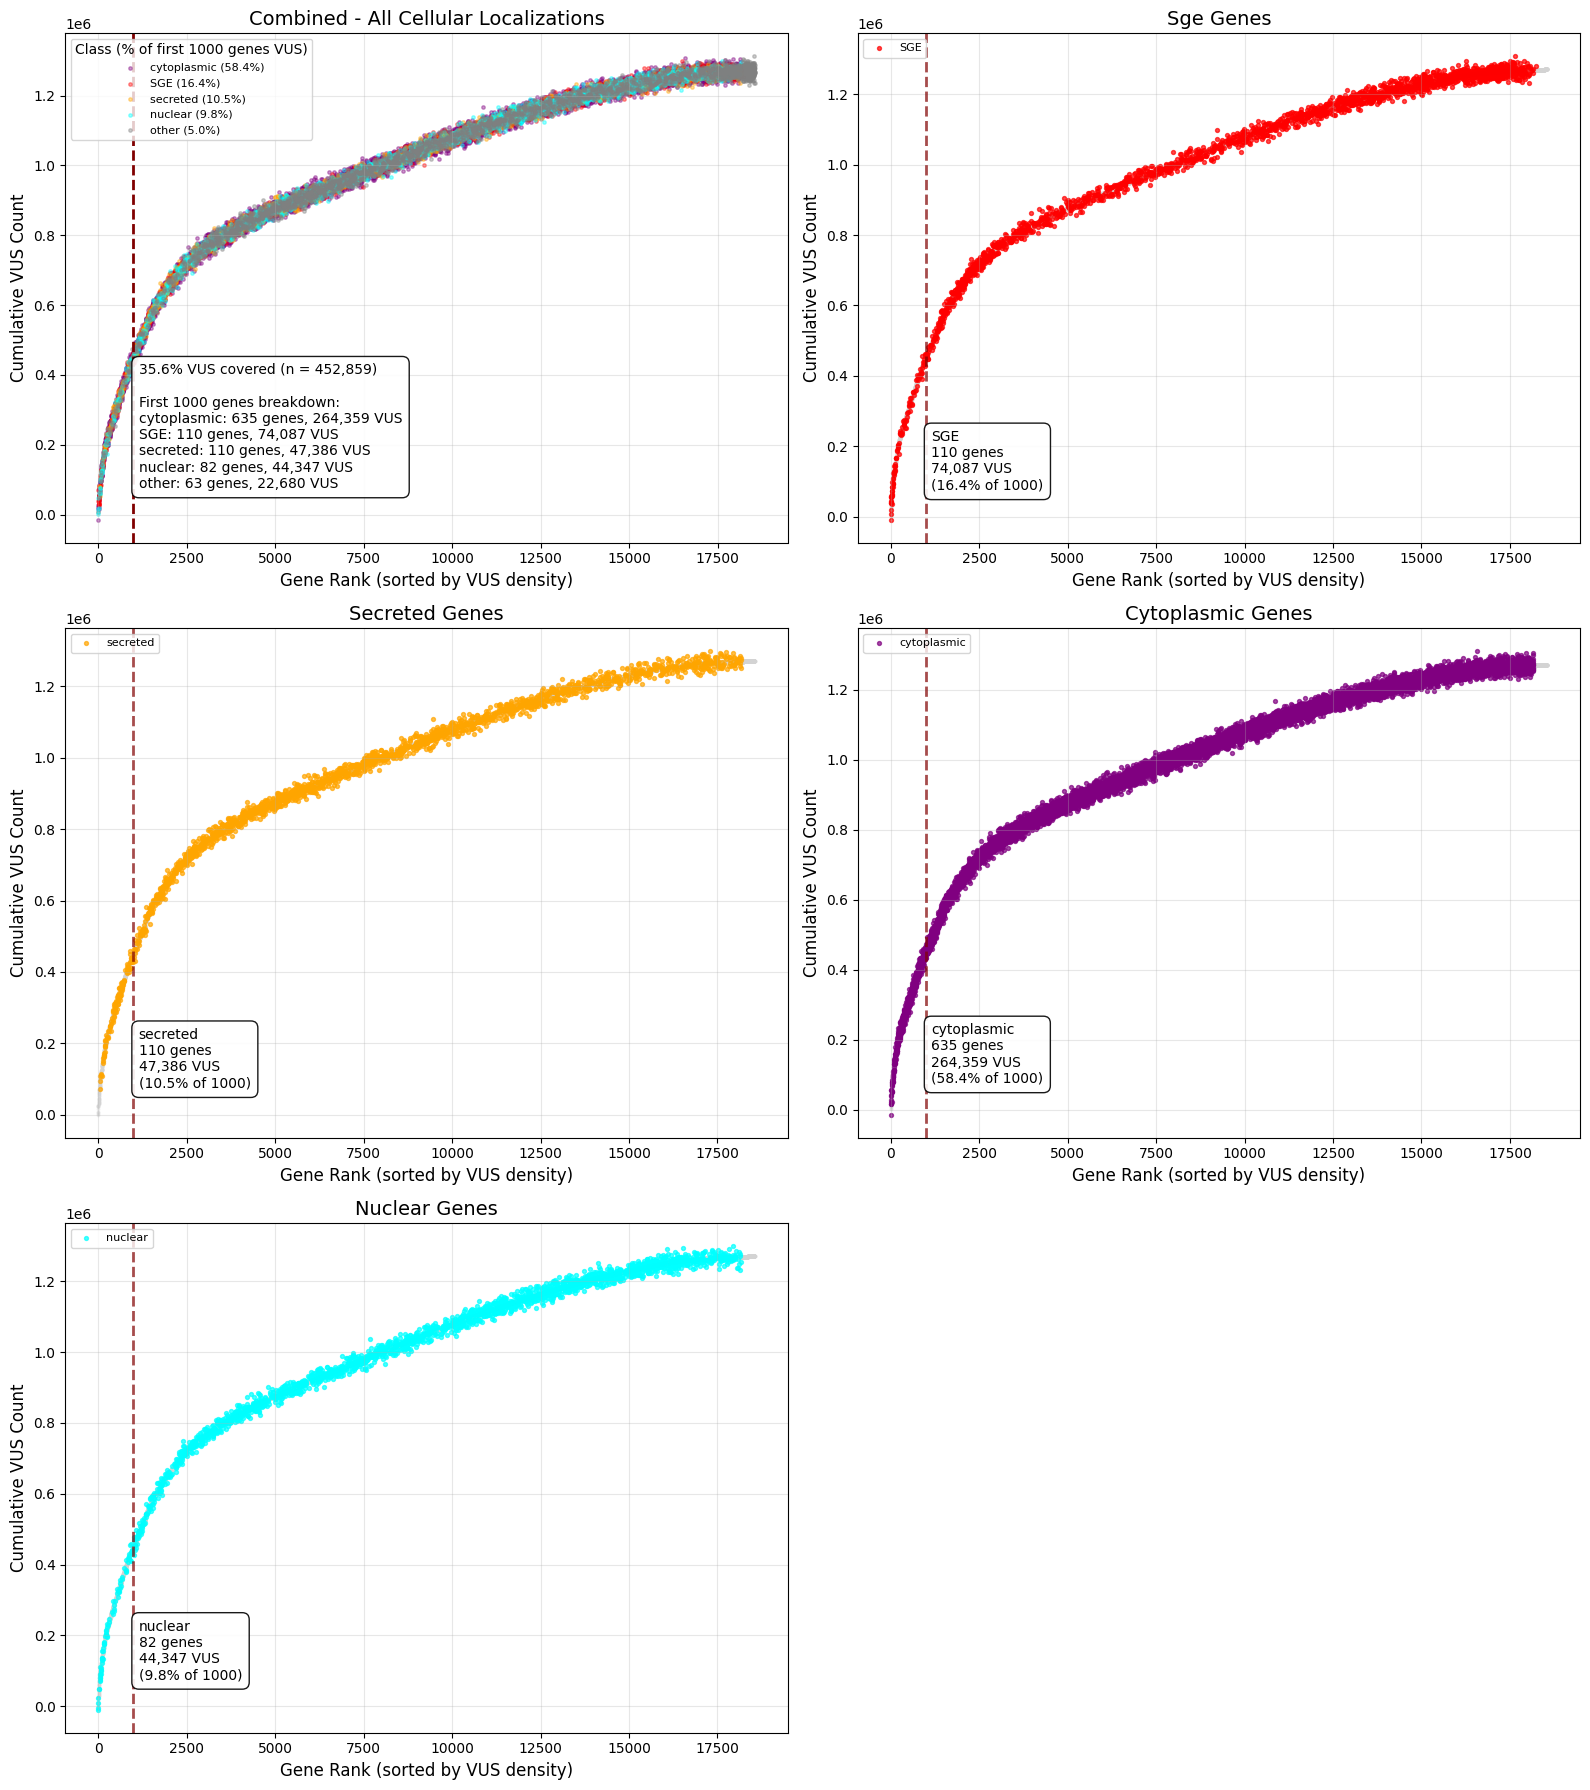

In [28]:
plot_vus_collectors_curve_four_panel(CV_missense_hap1_loc_len)

In [30]:
CV_missense_hap1_loc_len['ClinicalSignificance'] = CV_missense_hap1_loc_len['ClinicalSignificance'].replace({
    'Pathogenic/Likely pathogenic': 'Likely pathogenic',
    'Benign/Likely benign': 'Likely benign'
})

In [31]:
# Specify only the columns that are variant-specific (that we DON'T want to keep as-is)
variant_specific_columns = ['ClinicalSignificance']  # Add any other variant-specific columns here

# Get all other columns EXCEPT GeneSymbol (since it's the groupby key)
gene_level_columns = [col for col in CV_missense_hap1_loc_len.columns 
                     if col not in variant_specific_columns and col != 'GeneSymbol']

# For gene-level columns, take the first value for each gene (they should be the same anyway)
gene_info = CV_missense_hap1_loc_len.groupby('GeneSymbol')[gene_level_columns].first().reset_index()

# Get counts for each ClinicalSignificance class per gene
significance_counts = CV_missense_hap1_loc_len.groupby('GeneSymbol')['ClinicalSignificance'].value_counts().unstack(fill_value=0)
significance_counts = significance_counts.reset_index()
significance_counts.columns.name = None

# Merge gene info with significance counts
collapsed_df = pd.merge(gene_info, significance_counts, on='GeneSymbol', how='left')

# Fill any NaN values in count columns with 0
count_columns = [col for col in collapsed_df.columns if col not in gene_level_columns + ['GeneSymbol']]
for col in count_columns:
    collapsed_df[col] = collapsed_df[col].fillna(0).astype(int)

print(f"Original dataframe shape: {CV_missense_hap1_loc_len.shape}")
print(f"Collapsed dataframe shape: {collapsed_df.shape}")
print(f"Columns kept: {len(gene_level_columns) + 1}")  # +1 for GeneSymbol
print(f"Count columns added: {len(count_columns)}")
print(f"Total columns in collapsed df: {len(collapsed_df.columns)}")

Original dataframe shape: (1505844, 68)
Collapsed dataframe shape: (18948, 81)
Columns kept: 67
Count columns added: 14
Total columns in collapsed df: 81


In [32]:
collapsed_CV_missense_hap1_loc_len = collapsed_df

In [33]:
#now filter on gencc moderate and above
CV_missense_hap1_loc_len_gencc = pd.merge(CV_missense_hap1_loc_len, unique_gencc, 
                                          left_on='GeneSymbol', right_on='gene_symbol', 
                                          how='inner')

NameError: name 'unique_gencc' is not defined

In [ ]:
# Specify only the columns that are variant-specific (that we DON'T want to keep as-is)
variant_specific_columns = ['ClinicalSignificance']  # Add any other variant-specific columns here

# Get all other columns EXCEPT GeneSymbol (since it's the groupby key)
gene_level_columns = [col for col in CV_missense_hap1_loc_len_gencc.columns 
                     if col not in variant_specific_columns and col != 'GeneSymbol']

# For gene-level columns, take the first value for each gene (they should be the same anyway)
gene_info = CV_missense_hap1_loc_len_gencc.groupby('GeneSymbol')[gene_level_columns].first().reset_index()

# Get counts for each ClinicalSignificance class per gene
significance_counts = CV_missense_hap1_loc_len_gencc.groupby('GeneSymbol')['ClinicalSignificance'].value_counts().unstack(fill_value=0)
significance_counts = significance_counts.reset_index()
significance_counts.columns.name = None

# Merge gene info with significance counts
collapsed_df = pd.merge(gene_info, significance_counts, on='GeneSymbol', how='left')

# Fill any NaN values in count columns with 0
count_columns = [col for col in collapsed_df.columns if col not in gene_level_columns + ['GeneSymbol']]
for col in count_columns:
    collapsed_df[col] = collapsed_df[col].fillna(0).astype(int)

print(f"Original dataframe shape: {CV_missense_hap1_loc_len_gencc.shape}")
print(f"Collapsed dataframe shape: {collapsed_df.shape}")
print(f"Columns kept: {len(gene_level_columns) + 1}")  # +1 for GeneSymbol
print(f"Count columns added: {len(count_columns)}")
print(f"Total columns in collapsed df: {len(collapsed_df.columns)}")

In [ ]:
collapsed_CV_missense_hap1_loc_len_gencc = collapsed_df